<h1> Bild Klassifizierung mit Hilfe einer CNN-Architektur</h1>

<h2> Einleitung </h2>
In diesem Projekt widmen wir uns dem allseits bekannten cifar10 Datensatz. Dieser beinhaltet 60000 Bilder in 32x32 Pixel mit 10 unterschiedlichen Klassen. Dieser Datensatz ist ein guter Startpunkt im Machine Learning um eine effiziente CNN-Archtiektur zu erproben. 
Der Ansatz den wir hier gewaehlt haben ist eine CNN-Architektur, mit mehreren Schichten. Zu Beginn wollen wir aber unseren Datensatz ergruenden und auf mehrere Weisen praesentieren. Um zu erkunden wie die Bilder und Formen der Daten denn aussehen, wie viele Klassen es gibt und vor allem wie diese Klassen prozentual im Datensatz vorkommen.  

<b><u>Inhaltsverzeichnis</b></u>
<ol = type"1">
    <li>Daten Exploration</li>
    <li>Netzwerk Architektur</li>
        <ol type="1">
            <li>Trainingsfunktion</li>
        </ol>
    <li>Analyse der Ergebnisse</li>
</ol>


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.utils import to_categorical, np_utils

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 1. Daten Exploration
In diesem Abschnitt widmen wir uns dem Datensatz. Zu Beginn laden wir unseren cifar10-Datensatz mit einer eigenen Methode. Dies ist best practice, da wir in dem Fall, dass wir mit einem nicht lokal ausfuehrbaren/speicherbaren Datensatz arbeiten, oder in einem zukuenftigen Projekt cifar10 erneut laden moechten am besten eine Methode importieren/anpassen wollen.  
Anschliessend lassen wir die Formen unserer Trainingsdaten in der Output-Zelle ausgeben und erkennen so, wie gross die respektiven Datensaetze sind, sowie deren Form. Dies hilft uns spaeter, wenn wir die Daten aufbereiten und in eine verarbeitbaren Zustand bringen wollen, Entscheidungen zu treffen die unsere Netzwerk Architektur optimiert.  
Danach importieren wir die 10 Klassen in eine Liste und lassen in einem pie Chart ausgeben, wie diese 10 Klassen prozentual im Datensatz vertreten sind. Anschliessend wollen wir uns auch einmal 25 Bilder sowie deren Klassennamen in einem 5x5 Grid ausgeben lassen. Hierbei wird direkt eine Herausforderung des cifar10-Datensatz deutlich: Die Bilder (im vgl. zu bspw MNIST - welches Bilder in "grayscale" ausgibt) sind farblich. Dies bedeutet dass unsere Datensaetze einen sog. Channel(siehe Shape eines Bildes=(32,32,3)) haben fuer jede Farbe. Jede Farbe wird hier als eine Zusammensetzung aus Rot/Gruen/Blau wiedergeben. Dies zeigt uns, dass wir bei diesem Projekt unsere Daten anpassen muessen, wie wir spaeter sehen werden.  
Eine weitere Herausforderung die wir hier sehen ist, dass die Bilder doch teilweise auch fuer das menschliche Auge schwer auseinanderzuhalten sind. Wie sich ergeben hat, ist die durchschnittliche Benchmark eines Menschen, der die cifar10-Bilder kategorisiert "nur" mit 94% Genauigkeit angegeben. Ein Wert an dem wir uns orientieren koennen um die Ergebnisse unseres CNN spaeter einzuordnen.

Training Datensatz Shape: (50000, 32, 32, 3)
Training Labels Shape: (50000, 1)
Test Datensatz Shape: (10000, 32, 32, 3)
Test Labels Shape: [[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
Shape eines Bildes: (32, 32, 3)


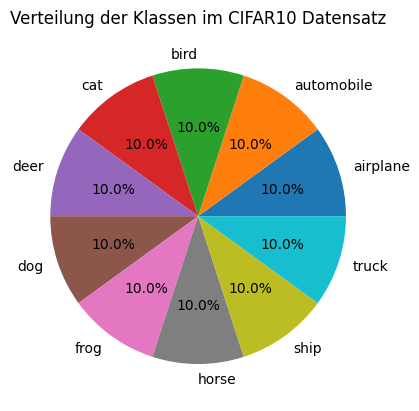

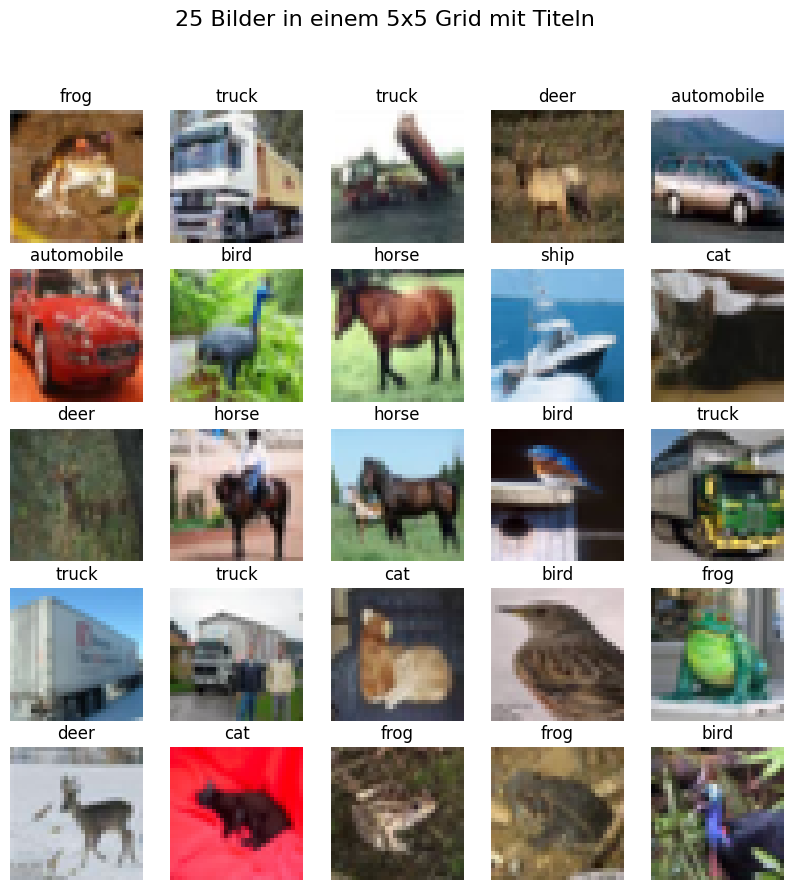

In [17]:
def load_cifar10():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_cifar10()

#Exploration der Form unserer Datensaetze
print('Training Datensatz Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Test Datensatz Shape:', X_test.shape)
print('Test Labels Shape:', y_test)
print('Shape eines Bildes:', X_train[0].shape)

#Exploration der Klassenverteilung im Datensatz
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_counts = [len(np.where(y_train == i)[0]) for i in range(10)]
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%')
plt.title('Verteilung der Klassen im CIFAR10 Datensatz')    

#Darstellung von 25 Bildern des Datensatzes in einem 5x5Grid
fig, axs = plt.subplots(5, 5, figsize=(10,10))
fig.suptitle('25 Bilder in einem 5x5 Grid mit Titeln', fontsize=16)
axs = axs.flatten()
for i in range(25):
    img = X_train[i]
    label = class_names[y_train[i][0]]
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

<h1> 2. CNN Architektur </h1>

Nun, da wir unseren Datensatz erkundet haben gilt es die Daten vorzubereiten. Wir benutzen hierfuer eine eigens entwickelte Funktion "to_OneHot" um die Validierungsdatensaetze in ein [1,0,1,0] Format zu bringen, was spaeter erkennbare Leistungsunterschiede machen wird. Ferner werden auch unser X_train und X_test Datensaetze in das richtige Format gebracht, in dem wir die Daten zunaechst in Type float32 umwandeln. Nun wird bedacht, dass es sich bei den 32x32, 3 Channel dargestellen cifar10 Bildern um RGB Bilder handelt und unsere gerade eben in float32 umgewandelten Datensaetze durch 255 geteilt um eine Klassifizierung fuer das Model einfacher zu machen.  
Genug von der Vorbereitung der Daten, wir wollen uns nun daran machen unser Model zu definieren. Dazu benutzen wir eigens erstelle Funktionen, die entweder ein einzelnes Layer dem CNN hinzufuegen, oder gar einen ganzen Block an Layern dem Netzwerk hinzufuegen. Ich habe diesen Ansatz gewaehlt, da es spaeter, sobald unser Netzwerk funktionsfaehig ist, den Prozess die "optimale" Architektur zu finden extrem vereinfacht. Beispielsweise koennen wir beliebig viele, sowie grosse Layer hinzufuegen und entfernen. Sowie ganze Layerbloecke hinzufuegen. Ferner ist dies fuer Hyperparameter tuning ausgezeichnet einfach, da diese sehr einfach bearbeitet werden koennen und bspw. [Regularisierung](https://en.wikipedia.org/wiki/Regularization_(mathematics)#Regularizers_for_multitask_learning) einfach pro Layer angepasst werden kann. Diese gezielte Kontrolle ueber unsere Netzwerk Architektur kommt uns vor allem in der main Methode zugute, da wir dort mit Hilfe unserer Funktionen ein Netzwerk nach der geplanten Architektur initialisieren koennen.  
  
Unsere gewaehlte Architektur sieht wie folgt aus:  
<ol type="1">
    <li>Layer Block #1</li>
        <ol type="1">
            <li>Batch Normalization Layer (forward)</li>
            <li>Conv2D Layer: 32 Filter, 3x3 Kernel, ReLu, L2 Regularizer(0.0001) Rate</li>
            <li>Conv2D Layer: 32 Filter, 3x3 Kernel, ReLu, L2 Regularizer(0.0001) Rate</li>
            <li>Max Pooling 2D Layer: Size=2x2</li>
        </ol>
    <li>Layer Block #2</li>
        <ol type="1">
            <li>Batch Normalization Layer (forward)</li>
            <li>Conv2D Layer: 64 Filter, 3x3 Kernel, ReLu, L2 Regularizer(0.0001) Rate</li>
            <li>Conv2D Layer: 64 Filter, 3x3 Kernel, ReLu, L2 Regularizer(0.0001) Rate</li>
            <li>Max Pooling 2D Layer: Size=2x2</li>
        </ol>
    <li>Single Layer</li>
        <ol type="1">
            <li>Batch Normalization Layer (forward)</li>
            <li>Conv2D Layer: 128 filter, 3x3 Kernel, ReLu, L2 Regularizer(0.0001) Rate</li>
            <li>MaxPooling 2D Layer: Size=2x2</li>
            <li>Dropout Layer: 0.2 Rate</li>
        </ol>
    <li>Input Layer</li>
        <ol type="1">
            <li>Flatten Layer</li>
        </ol>
    <li>Hidden Layer</li>
        <ol type="1">
            <li>Dense Layer: 512 Neuronen, ReLu</li>
            <li>Batchnormalization Layer</li>
            <li>Dropout Layer: 0.2 Rate</li>
        </ol>
    <li>Output Layer</li>
        <ol type="1">
            <li>Dense Layer: 10 Neuronen, softmax (passend zur Loss-Funktion: categorical crossentropy)</li>
        </ol>
</ol>

## 2.1 Trainingsfunktion
Die Netzwerk Architektur ist nun abgeschlossen und das Model muss noch compiliert und gefitted werden.   
Dies wird ueber eine eigene Funktion('train_cnn') ausgefuehrt. Diese erhaelt neben dem Model-Namen unsere Datensaetze als Parameter. Ausserdem wird hier schon die Anzahl der Epochen (40) und die Groesse der Batches (64) festgelegt. Auch legt diese Funktion fest, dass die gpu benutzt wird um das Training des Netzwerkes zu uebernehmen. Ein weiterer Vorteil dieser Weise um das Model zu trainieren und kompilieren ist, dass wir hier den optimizer mit seinen Lernraten und dem Weight Decay direkt festlegen koennen. Fuer dieses Netzwerk wurde der [ADAM Algorithmus](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) gewaehlt um unser Model zu optimieren. Wir haben die Lernrate als Parameter festgelegt und das Weight Decay auf 1e-4 bestimmt.  
Nun ist es Zeit, unsere gewaehlte Netzwerkstruktur, in einer Main Methode festzulegen. Anschliessend rufen wir die train_cnn-Funktion auf und uebergeben unser sequentielles Model als Parameter. Zu guter Letzt rufen wir unsere Main Methode auf und bestaunen in der Output-Zelle unsere 40 Trainingsepochen.  
Um festzulegen ob die 40 Epochen unseren Erwartungen gerecht werden geben wir die Genauigkeit des Models aus dem Validierungsdatensatz aus. Dadurch koennen wir erkennen, ob sich unser Netzwerk generalisieren laesst und nicht einfach nur eine gute Traininsgenauigkeit besitzt. Ausserdem bietet die Ausgabe in der Output-Zelle die Erkenntnis ob unsere Datenanpassung gut waren oder ob das Model ueber-/unterangepasst auf unseren Datensatz ist.

In [18]:
# Hilfsfunktionen:
#   1. y_train/y_test in OneHot Encoding Format umwandeln
#   2. Layer fuer unser CNN erstellen
#   3. Fully Connected Layer zu unserem CNN hinzufuegen
#   4. eine Trainingsmethode um das CNN zu trainieren

def to_OneHot(y_train, y_test, num_classes=10):
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test  = tf.keras.utils.to_categorical(y_test, num_classes)
    return y_train, y_test

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train, X_test = X_train / 255, X_test / 255
y_train, y_test = to_OneHot(y_train, y_test)
input_shape = X_train.shape[1:]

#Hier wurde versucht mit Hilfe von Data Augmentation gegen das overfitting des Models vorzugehen,
#blieb leider ohne Erfolg - jedoch als Legacy Code behalten. Die Trainingsfunktion etc. werden ohne datagen genutzt.
#
#datagen = ImageDataGenerator(
#    rotation_range=20,         
#    width_shift_range=0.2,      
#    height_shift_range=0.2,     
#    horizontal_flip=True,       
#    fill_mode='nearest'         
#)
#datagen.fit(X_train)
#train_generator = datagen.flow(X_train, y_train, batch_size=64)

def add_Single_Layer(model, num_filters, kernel_size=(3,3), activation='relu', input_shape=input_shape):
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, kernel_size, padding='same', activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    return model


def add_Layer_Block(num_blocks, model, num_filters, kernel_size=(3,3), activation='relu', input_shape=input_shape):
    for i in range(num_blocks):
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, kernel_size, padding='same', activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
        model.add(Conv2D(num_filters, kernel_size, padding='same', activation=activation, kernel_regularizer=regularizers.l2(0.0001)))
        model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    return model

def add_fullyConnected(model, num_classes=10, input_shape=input_shape, num_layers=1, num_neurons=128, activation='relu', dropout_rate=0.2):
    # Input layer
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    # Hidden layers
    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(num_neurons * 4, activation=activation))
        tf.keras.layers.BatchNormalization()
        model.add(tf.keras.layers.Dropout(dropout_rate))
    # Output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

def train_cnn(model, X_train, y_train, X_test, y_test, epochs=40, batch_size=64):
    with tf.device('/gpu:0'):
        weight_decay = 1e-4
        optimizer = Adam(lr=0.001, decay=weight_decay)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
        test_loss, test_acc = history.model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)
    return model


#Erstellung unseres Classifier Models als Sequentielles Model
def main():
    #model init, training, eval
    img_classifier = Sequential()
    img_classifier = add_Layer_Block(1, img_classifier, 32)
    img_classifier = add_Layer_Block(1, img_classifier, 64)
    img_classifier = add_Single_Layer(img_classifier,128)
    img_classifier = add_fullyConnected(img_classifier)
    img_classifier = train_cnn(img_classifier, X_train, y_train, X_test, y_test)

if __name__ == '__main__':
    main()

Epoch 1/40
782/782 [==============================] - 49s 62ms/step - loss: 1.3533 - accuracy: 0.5242 - val_loss: 0.9705 - val_accuracy: 0.6657
Epoch 2/40
782/782 [==============================] - 50s 63ms/step - loss: 0.8888 - accuracy: 0.6983 - val_loss: 0.8790 - val_accuracy: 0.7024
Epoch 3/40
782/782 [==============================] - 54s 70ms/step - loss: 0.7174 - accuracy: 0.7606 - val_loss: 0.7194 - val_accuracy: 0.7662
Epoch 4/40
782/782 [==============================] - 53s 68ms/step - loss: 0.6099 - accuracy: 0.8020 - val_loss: 0.6457 - val_accuracy: 0.7886
Epoch 5/40
782/782 [==============================] - 48s 61ms/step - loss: 0.5275 - accuracy: 0.8320 - val_loss: 0.6699 - val_accuracy: 0.7886
Epoch 6/40
782/782 [==============================] - 48s 62ms/step - loss: 0.4642 - accuracy: 0.8528 - val_loss: 0.6544 - val_accuracy: 0.7987
Epoch 7/40
782/782 [==============================] - 49s 63ms/step - loss: 0.4071 - accuracy: 0.8756 - val_loss: 0.6211 - val_accuracy:

# Analyse der Ergebnisse
Das Modell erreichte eine endgueltige Testgenauigkeit von 83,52%, was ein anstaendiges Ergebnis für diesen Datensatz ist. Wenn wir uns die Trainingskurve ansehen, koennen wir sehen, dass das Modell mit einer Trainingsgenauigkeit von etwa 52% beginnt und sich mit jedem Durchgang allmaehlich verbessert und schließlich eine Trainingsgenauigkeit von fast 99% erreicht. Womit immerhin im Trainingssatz ein Mensch geschlagen wird - 94% Genauigkeit. Aehnlich beginnt die Validierungsgenauigkeit bei etwa 66% und verbessert sich ebenfalls stetig, erreicht einen Hoechstwert von 83% um die 20. Epoch herum und bleibt dann konstant.

Interessanterweise scheint die Validierungsgenauigkeit um die 30. Epoche herum einen leichten Rueckgang zu verzeichnen, bevor sie in den letzten Durchgaengen wieder steigt. Dies koennte ein Zeichen für Overfitting sein, aber da die endgueltige Testgenauigkeit immer noch relativ hoch ist, ist es kein großes Problem. Es wurde auch versucht , wie im Code als Legacy Code gekennzeichnet, dieses Overfitting mittels Data Augmentation Techniken zu loesen. Dies fuehrte jedoch nicht zum gewuenschten Erfolg, die Funktion wurde jedoch trotzdem im Code behalten. Um Overfitting zu bekaempfen setzt diese CNN-Architektur jedoch auf L2 Regularization, Dropout Layer sowie BatchNormalization Layer.

In Bezug auf die Recheneffizienz dauerte das Training des Modells auf einem GTX 3050 TI Laptop etwa 30 Minuten, was eine angemessene Zeit fuer ein Deep-Learning-Modell dieser Groeße ist.

Insgesamt laesst diese Analyse darauf schließen, dass das Modell eine solide Leistung auf dem cifar10-Datensatz erbringt und eine respektable Genauigkeit bei angemessenen Rechenressourcen erreicht. Es sind jedoch weitere Experimente und Optimierungen erforderlich, um gerade dem Problem des Overfittings auf den Grund zu gehen und eine hoehere Validierungsgenauigkeit zu erreichen. Ferner bin ich der Meinung, dass die ohnehin schon simple Netzwerk Architektur aus einem 32-Filter-Layerblock, 64-Filter-Layerblock und einem einzelnen 128-Filter-Layer weiter vereinfacht werden koennte um bessere Ergebnisse zu erzielen.

<details>
    <summary> LEGAL DISCLAIMER </summary>
This website and its content are for educational and informational purposes only. All information and content provided on this site are the property of their respective owners. We do not claim any ownership, affiliation or endorsement of any of the products or brands mentioned on this website.

We do not make any warranties or representations concerning the accuracy or completeness of any information or content displayed on this website. We also do not guarantee that this website or its content will be error-free or uninterrupted.

Any reliance you place on such information is strictly at your own risk. We shall not be held liable for any loss or damage caused by your reliance on any information or content contained in this website.

All trademarks, logos and brand names appearing on this website are the property of their respective owners. Any use of such trademarks, logos or brand names is solely for informational and descriptive purposes, and does not imply an endorsement or sponsorship by the owners of such trademarks, logos or brand names.

Finally, we reserve the right to modify or discontinue, temporarily or permanently, this website and its content without prior notice to you.
</details>